# Clustering Maddo

In [2]:
import pandas as pd
import numpy as np     
import matplotlib.pyplot as plt
import seaborn as sns

fragmenten_df = pd.read_csv('Data/fragments_data.csv')
birchFragmenten_df = fragmenten_df.copy()
birchFragmenten_df.head()

,fragment,labels,label_numeric
0,05190.100417.watersniproepEempolder_fragment_0...,watersnip,0
1,05190.100417.watersniproepEempolder_fragment_1...,watersnip,0
2,05190.100417.watersniproepEempolder_fragment_2...,watersnip,0
3,05190.100417.watersniproepEempolder_fragment_3...,watersnip,0
4,05190.100417.watersniproepEempolder_fragment_4...,watersnip,0


In [3]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(birchFragmenten_df, test_size=0.3, random_state=42)
test_data.head()

,fragment,labels,label_numeric
948,XC466471-Redshank (2)_fragment_0.wav,tureluur,1
3036,XC749107-2022-09-14 2020 Oeverlopers_fragment_...,oeverloper,4
1960,XC590410-200918_0480_2257_Watersnip_fragment_1...,watersnip,0
3543,XC834752-01.-1950-2050-watersnip_fragment_5.wav,watersnip,0
1689,"XC561755-Oeverloper, flight call, IGS, 050520,...",oeverloper,4


In [4]:
label_counts = test_data['labels'].value_counts()
print(label_counts)

labels
tureluur                  362
oeverloper                256
witgat                    202
watersnip                 170
zwarte ruiter             149
geelpootruiter             11
grauwe franjepoot          10
steenloper                  7
steltloper                  3
amerikaanse oeverloper      1
Name: count, dtype: int64


In [5]:
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import pandas as pd
from scipy.signal import stft
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AffinityPropagation

In [6]:
# Initialize the features and filenames lists
features = []
filenames = []

for fragment in test_data['fragment']:
    y, sr = librosa.load("audio_fragments/" + fragment, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc.T, axis=0)

    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma.T, axis=0)

    stft_librosa = librosa.stft(y, n_fft=1024, hop_length=512)
    stft_librosa_mean = np.mean(np.abs(stft_librosa))

    feature_vector = np.concatenate([mfcc_mean, chroma_mean, [stft_librosa_mean]])
    features.append(feature_vector)
    filenames.append(fragment)

features = np.array(features)

scaler = StandardScaler()
features = scaler.fit_transform(features)

distance_matrix = squareform(pdist(features, metric='euclidean'))


c:\Users\madel\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\madel\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\madel\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,
c:\Users\madel\anaconda3\Lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
c:\Users\madel\anaconda3\Lib\site-packages\

In [7]:
from sklearn.manifold import TSNE

# Ensure features array is valid before applying t-SNE
if np.isnan(features).any() or np.isinf(features).any():
    print("Error: Features array contains NaN or infinite values. Please check your data.")
else:
    tsne = TSNE(n_components=2, random_state=42)
    features_tsne = tsne.fit_transform(features)

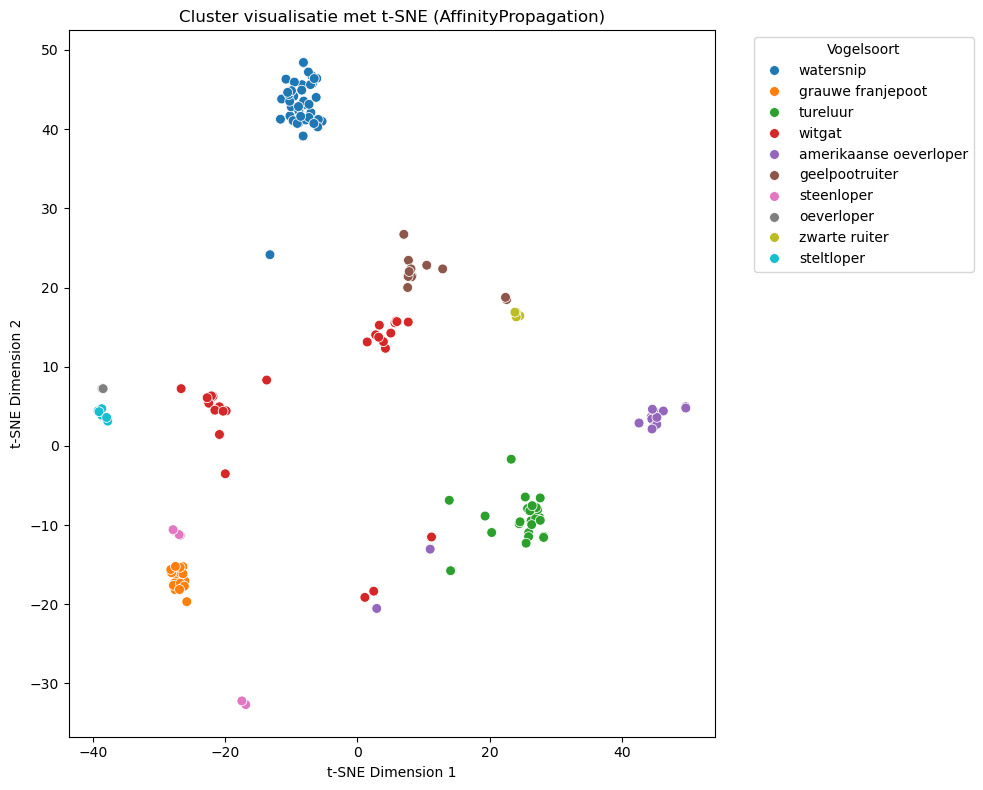

In [8]:
# Pas Affinity clustering toe op de features
affinity = AffinityPropagation(random_state=42)
affinity_labels = affinity.fit_predict(features)

# Voeg de labels toe aan de dataset
# Map the Affinity cluster labels to the bird names using the test_data labels
# Voeg de labels toe aan de dataset
species_labels_affinity = [
    test_data.loc[test_data['label_numeric'] == label, 'labels'].iloc[0]
    if label in test_data['label_numeric'].values else 'Onbekend'
    for label in affinity_labels
]

# Filter de gegevens om "Onbekend" te verwijderen
filtered_indices_affinity = [i for i, label in enumerate(species_labels_affinity) if label != 'Onbekend']
filtered_features_tsne_affinity = features_tsne[filtered_indices_affinity]
filtered_species_labels_affinity = [species_labels_affinity[i] for i in filtered_indices_affinity]

# Plot de clusters zonder "Onbekend"
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=filtered_features_tsne_affinity[:, 0],
    y=filtered_features_tsne_affinity[:, 1],
    hue=filtered_species_labels_affinity,
    palette='tab10',
    s=50
)
plt.title("Cluster visualisatie met t-SNE (AffinityPropagation)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(
    title="Vogelsoort",
    bbox_to_anchor=(1.05, 1),   # Position legend outside the plot
    loc='upper left'
)
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

In [12]:
# Check if all points in each shown cluster have the same species label

# Get the species labels for the filtered indices
filtered_species_labels = [test_data['labels'].values[i] for i in filtered_indices_affinity]

import collections
for cluster_id in np.unique(filtered_species_labels_affinity):
    # Indices of points in this cluster
    indices_in_cluster = [i for i, c in enumerate(filtered_species_labels_affinity) if c == cluster_id]
    # Species labels for these points
    species_in_cluster = [filtered_species_labels[i] for i in indices_in_cluster]
    unique_species = set(species_in_cluster)
    if len(unique_species) == 1:
        print(f"Cluster {cluster_id}: OK ({list(unique_species)[0]})")
    else:
        print(f"Cluster {cluster_id}: X {unique_species}")

Cluster amerikaanse oeverloper: OK (tureluur)
Cluster geelpootruiter: X {'oeverloper', 'witgat', 'tureluur', 'zwarte ruiter'}
Cluster grauwe franjepoot: X {'witgat', 'watersnip'}
Cluster oeverloper: OK (oeverloper)
Cluster steenloper: X {'oeverloper', 'tureluur', 'witgat'}
Cluster steltloper: X {'tureluur', 'watersnip'}
Cluster tureluur: X {'oeverloper', 'tureluur', 'witgat', 'zwarte ruiter'}
Cluster watersnip: X {'zwarte ruiter', 'oeverloper', 'tureluur', 'witgat', 'watersnip'}
Cluster witgat: X {'zwarte ruiter', 'tureluur', 'oeverloper', 'witgat', 'grauwe franjepoot', 'watersnip'}
Cluster zwarte ruiter: OK (oeverloper)


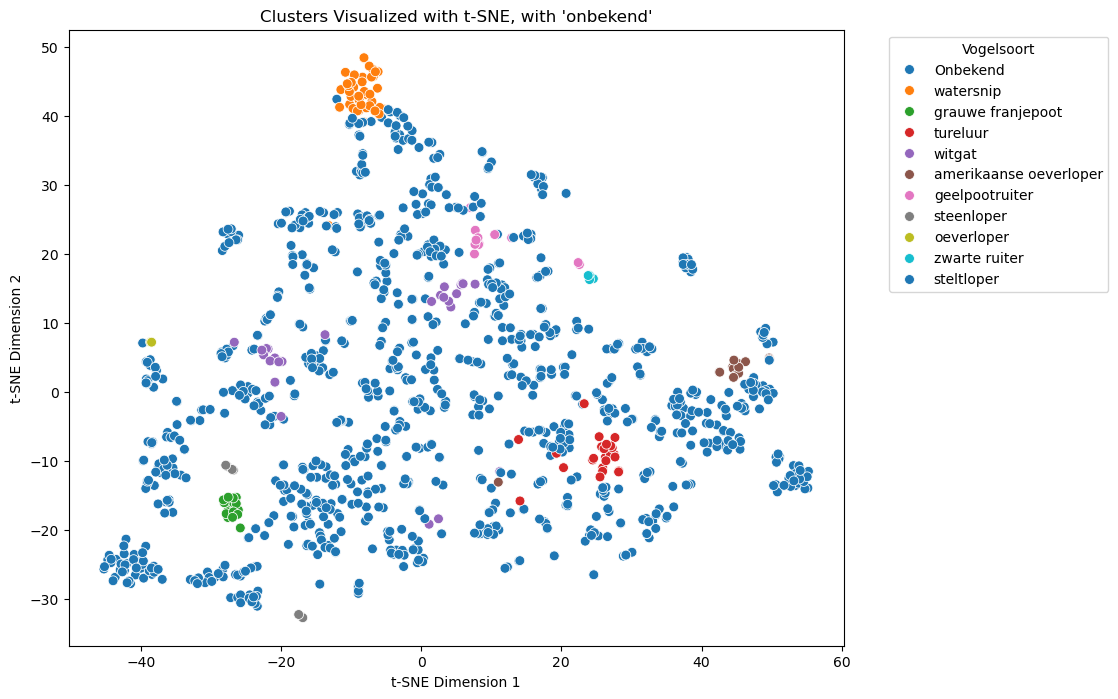

In [ ]:

# # Visualize clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=species_labels_affinity, palette='tab10', s=50)
plt.title("Clusters Visualized with t-SNE, with 'onbekend'")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(
    title="Vogelsoort",
    bbox_to_anchor=(1.05, 1),   # Position legend outside the plot
    loc='upper left'
)
plt.show()

In [ ]:
# Print the number of clusters found by AffinityPropagation
n_clusters = len(np.unique(affinity_labels))
print(f"Aantal clusters gevonden door AffinityPropagation: {n_clusters}")

Aantal clusters gevonden door AffinityPropagation: 84


In [ ]:
from IPython.display import Audio, display

# Vind indices van fragmenten met label 'Onbekend'
onbekend_indices = [i for i, label in enumerate(species_labels_affinity) if label == 'Onbekend']

# Eerste 4 fragmenten met label 'Onbekend'
for idx in onbekend_indices[:4]:
    fragment_name = test_data['fragment'].values[idx]
    print(f"Playing: {fragment_name}")
    fragment_row = test_data.iloc[idx]
    display(fragment_row)
    display(Audio(f"audio_fragments/{fragment_name}"))

Playing: XC466471-Redshank (2)_fragment_0.wav


fragment         XC466471-Redshank (2)_fragment_0.wav
labels                                       tureluur
label_numeric                                       1
Name: 948, dtype: object

Playing: XC749107-2022-09-14 2020 Oeverlopers_fragment_6.wav


fragment         XC749107-2022-09-14 2020 Oeverlopers_fragment_...
labels                                                  oeverloper
label_numeric                                                    4
Name: 3036, dtype: object

Playing: XC590410-200918_0480_2257_Watersnip_fragment_1.wav


fragment         XC590410-200918_0480_2257_Watersnip_fragment_1...
labels                                                   watersnip
label_numeric                                                    0
Name: 1960, dtype: object

Playing: XC834752-01.-1950-2050-watersnip_fragment_5.wav


fragment         XC834752-01.-1950-2050-watersnip_fragment_5.wav
labels                                                 watersnip
label_numeric                                                  0
Name: 3543, dtype: object